In [14]:
import torch# type: ignore
import torch.nn as nn# type: ignore
import torch.nn.functional as F# type: ignore
import torch.optim as optim# type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math

In [15]:
# 导入数据
file_path = r"C:\Users\79365\Desktop\多光谱数据\alldata\reflc.mat"
data = sio.loadmat(file_path)
# 提取X和Y
X = data['X']
Y = data['Y'] 

In [16]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# K折交叉验证
kf = KFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # 数据归一化
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1)).flatten()
    Y_test = scaler_Y.transform(Y_test.reshape(-1, 1)).flatten()

   


In [17]:
# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).unsqueeze(1)  # 增加维度适应Conv2d
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).unsqueeze(1)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3), keepdim=False)  # Global Average Pooling
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y  # Apply SE weights to the input

# Bottleneck Block with SE
class SEBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.se = SEBlock(out_channels * 4, reduction)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(x)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Apply SE Block
        out = self.se(out)

        out += identity
        out = self.relu(out)

        return out

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (3, 1), padding=(1, 0))  # First convolution
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((1, 1))  # Pooling layer

        self.conv2 = nn.Conv2d(16, 32, (3, 1), padding=(1, 0))  # Second convolution
        self.bn2 = nn.BatchNorm2d(32)

        self.se = SEBlock(32)  # SE block after second convolution

        self.fc = nn.Linear(32 * X_train.shape[1], 1)  # Adjust input size for the fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.se(x)  # Apply SE block

        x = torch.flatten(x, start_dim=1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x


In [18]:
# 初始化模型
model = ConvNet()


# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 优化器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)  # 学习率调度器

# 训练模型
num_epochs = 900
for epoch in range(num_epochs):
    model.train()
    
    # 前向传播
    outputs = model(X_train_tensor)
    loss = criterion(outputs.flatten(), Y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # 打印日志
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

# 测试模型
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions.flatten(), Y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [100/900], Loss: 0.0109, LR: 0.001000
Epoch [200/900], Loss: 0.0082, LR: 0.001000
Epoch [300/900], Loss: 0.0073, LR: 0.001000
Epoch [400/900], Loss: 0.0068, LR: 0.001000
Epoch [500/900], Loss: 0.0064, LR: 0.000100
Epoch [600/900], Loss: 0.0064, LR: 0.000100
Epoch [700/900], Loss: 0.0063, LR: 0.000100
Epoch [800/900], Loss: 0.0063, LR: 0.000100
Epoch [900/900], Loss: 0.0063, LR: 0.000100
Test Loss: 0.0086


In [19]:
# 在训练完成后保存模型
torch.save(model.state_dict(), 'trained_attention.pth')  # 保存模型的参数


In [20]:
# 创建一个新的模型实例
model = ConvNet()

# 加载保存的模型参数
model.load_state_dict(torch.load('trained_attention.pth'))

# 将模型设置为评估模式
model.eval()


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se): SEBlock(
    (fc1): Linear(in_features=32, out_features=2, bias=False)
    (fc2): Linear(in_features=2, out_features=32, bias=False)
    (sigmoid): Sigmoid()
  )
  (fc): Linear(in_features=800, out_features=1, bias=True)
)

In [21]:
# 模型预测
model.eval()
with torch.no_grad():
    Y_train_pred = model(X_train_tensor).flatten()
    Y_test_pred = model(X_test_tensor).flatten()

Training RMSE: 0.4390
Test RMSE: 0.5148
Training R²: 0.8927
Test R²: 0.8342
Test Rc: 0.9448
Test Rp: 0.9133


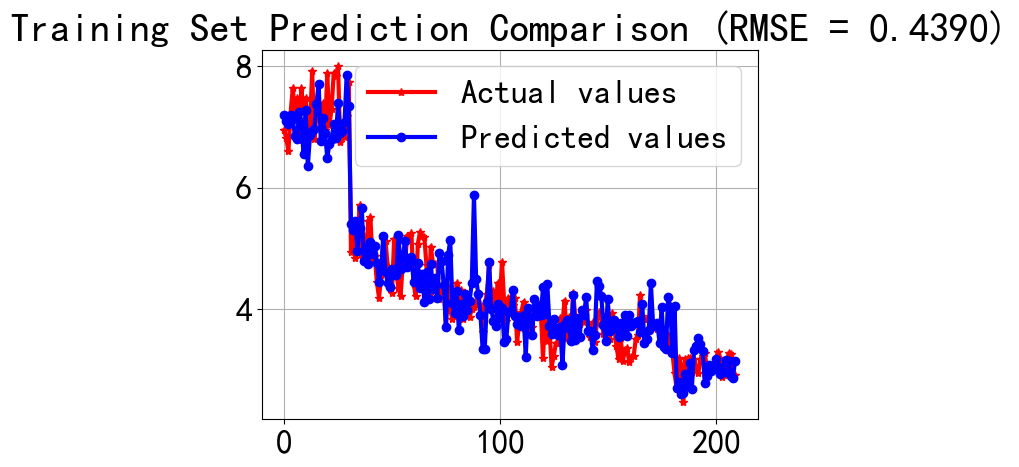

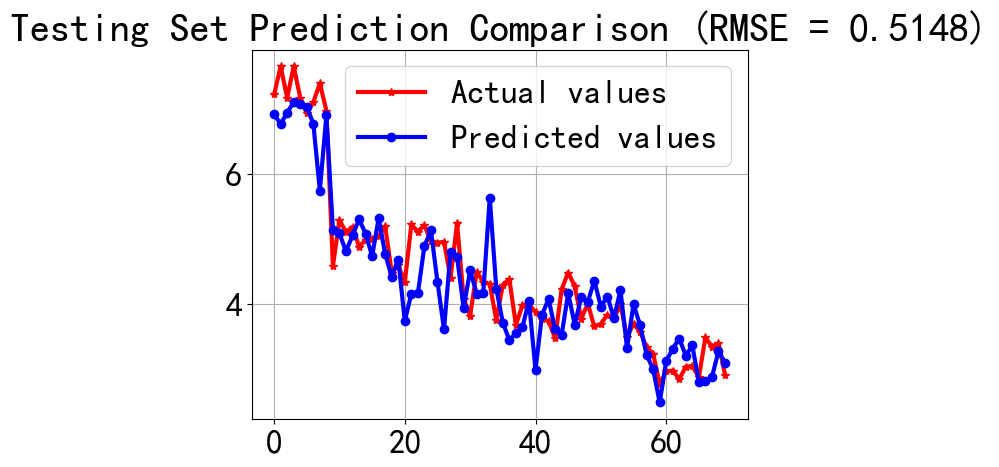

Training MAE: 0.3374
Test MAE: 0.3920
Training MBE: -0.0075
Test MBE: -0.1284
训练集数据的 RPD 为：3.0525
测试集数据的 RPD 为：2.4556


In [22]:
import matplotlib.pyplot as plt

# 设置字体为支持中文的字体，例如 SimHei
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Data inverse normalization
Y_train_pred = scaler_Y.inverse_transform(Y_train_pred.numpy().reshape(-1, 1)).flatten()
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.numpy().reshape(-1, 1)).flatten()
Y_train_actual = scaler_Y.inverse_transform(Y_train_tensor.numpy().reshape(-1, 1)).flatten()
Y_test_actual = scaler_Y.inverse_transform(Y_test_tensor.numpy().reshape(-1, 1)).flatten()

# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(Y_train_actual, Y_train_pred))
test_rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_test_pred))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
# R² coefficient calculation
train_r2 = 1 - np.sum((Y_train_actual - Y_train_pred) ** 2) / np.sum((Y_train_actual - np.mean(Y_train_actual)) ** 2)
test_r2 = 1 - np.sum((Y_test_actual - Y_test_pred) ** 2) / np.sum((Y_test_actual - np.mean(Y_test_actual)) ** 2)

print(f'Training R²: {train_r2:.4f}')
print(f'Test R²: {test_r2:.4f}')
Rc = math.sqrt(train_r2)
print(f'Test Rc: {Rc:.4f}')
Rp = math.sqrt(test_r2)
print(f'Test Rp: {Rp:.4f}')
# Plotting the prediction results
plt.figure()
plt.plot(Y_train_actual, 'r-*', label='Actual values')
plt.plot(Y_train_pred, 'b-o', label='Predicted values')
plt.title(f'Training Set Prediction Comparison (RMSE = {train_rmse:.4f})')
plt.legend()
plt.grid()

plt.figure()
plt.plot(Y_test_actual, 'r-*', label='Actual values')
plt.plot(Y_test_pred, 'b-o', label='Predicted values')
plt.title(f'Testing Set Prediction Comparison (RMSE = {test_rmse:.4f})')
plt.legend()
plt.grid()

plt.show()



# MAE and MBE calculation
train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
test_mae = mean_absolute_error(Y_test_actual, Y_test_pred)

train_mbe = np.mean(Y_train_pred - Y_train_actual)
test_mbe = np.mean(Y_test_pred - Y_test_actual)

print(f'Training MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Training MBE: {train_mbe:.4f}')
print(f'Test MBE: {test_mbe:.4f}')

# 计算基准数据（实际观测数据）的标准差
sd_reference_train = np.std(Y_train_actual)
sd_reference_test = np.std(Y_test_actual)

# 计算 RPD
rpd_train = sd_reference_train / train_rmse  # 使用训练集的 RMSE
rpd_test = sd_reference_test / test_rmse    # 使用测试集的 RMSE

# 显示结果
print(f'训练集数据的 RPD 为：{rpd_train:.4f}')
print(f'测试集数据的 RPD 为：{rpd_test:.4f}')


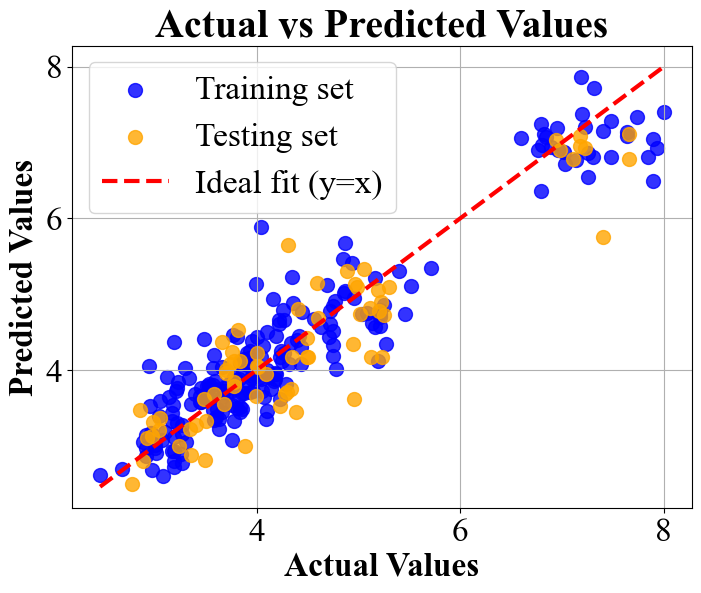

In [23]:
import matplotlib.pyplot as plt
# 调整字体
plt.rcParams['font.size'] = 24  # 设置全局字体大小
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 生成散点图比较真实值和预测值
plt.figure(figsize=(8, 6)) #尺寸  
plt.rcParams['lines.linewidth'] = 3  # 设置全局线宽
# 绘制训练集散点图
plt.scatter(Y_train_actual, Y_train_pred, c='blue', label='Training set', alpha=0.8, s=100)
plt.scatter(Y_test_actual, Y_test_pred, c='orange', label='Testing set', alpha=0.8, s=100)

# 绘制 y=x 参考线
max_val = max(Y_train_actual.max(), Y_test_actual.max())
min_val = min(Y_train_actual.min(), Y_test_actual.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal fit (y=x)')

# 设置图形标题和标签
plt.title('Actual vs Predicted Values', fontweight='bold')
plt.xlabel('Actual Values', fontweight='bold')
plt.ylabel('Predicted Values', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

